In [ ]:
# ===============================
# 1. Import Required Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
from google.colab import drive


In [ ]:
# ===============================
# 2. Load Dataset from Google Drive (Preprocessed Data)
# ===============================
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Preprocessed_Data_CSE4114_.csv"
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ===============================
# 3. Stratified Train-Test Split & Compute Class Weights
# ===============================
X = df['tokenized_sentence']
y = df['hate']  # 1 = Non-Hate, 0 = Hate

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Computed Class Weights: {class_weight_dict}")


Computed Class Weights: {0: 0.75, 1: 1.5}


In [ ]:
# ===============================
# 4. Optimized TF-IDF Feature Extraction
# ===============================
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=7000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nTF-IDF Complete: Training Shape = {X_train_tfidf.shape}")



TF-IDF Complete: Training Shape = (24000, 7000)


In [ ]:
# ===============================
# 5. Train & Evaluate Models (Using Class Weights)
# ===============================

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# --------- Train XGBoost ---------
print("\nTraining XGBoost Model...")
xgb_model = XGBClassifier(
    n_estimators=700,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=class_weight_dict[0]  # Apply class weights
)
xgb_model.fit(X_train_tfidf, y_train)
xgb_preds = xgb_model.predict(X_test_tfidf)
print("\nXGBoost Performance:\n", classification_report(y_test, xgb_preds))

# --------- Train SVM ---------
print("\nTraining SVM Model...")
svm_model = SVC(kernel='linear', C=1, class_weight=class_weight_dict, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)
print("\nSVM Performance:\n", classification_report(y_test, svm_preds))

# --------- Train Gradient Boosting ---------
print("\nTraining Gradient Boosting Model...")
gbt_model = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)
gbt_model.fit(X_train_tfidf, y_train)
gbt_preds = gbt_model.predict(X_test_tfidf)
print("\nGradient Boosting Performance:\n", classification_report(y_test, gbt_preds))

# --------- Train Naïve Bayes ---------
print("\nTraining Naïve Bayes Model...")
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)
print("\nNaïve Bayes Performance:\n", classification_report(y_test, nb_preds))



Training XGBoost Model...

XGBoost Performance:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      4000
           1       0.73      0.36      0.49      2000

    accuracy                           0.74      6000
   macro avg       0.74      0.65      0.66      6000
weighted avg       0.74      0.74      0.71      6000


Training SVM Model...

SVM Performance:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      4000
           1       0.56      0.60      0.58      2000

    accuracy                           0.71      6000
   macro avg       0.68      0.68      0.68      6000
weighted avg       0.71      0.71      0.71      6000


Training Gradient Boosting Model...

Gradient Boosting Performance:
               precision    recall  f1-score   support

           0       0.75      0.92      0.82      4000
           1       0.70      0.39      0.50      2000

    accuracy        

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# --------- Train KNN Model ---------
print("\nTraining KNN Model...")
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # Euclidean Distance
knn_model.fit(X_train_tfidf, y_train)
knn_preds = knn_model.predict(X_test_tfidf)
print("\nKNN Performance:\n", classification_report(y_test, knn_preds))



Training KNN Model...

KNN Performance:
               precision    recall  f1-score   support

           0       0.72      0.81      0.77      4000
           1       0.51      0.38      0.44      2000

    accuracy                           0.67      6000
   macro avg       0.62      0.60      0.60      6000
weighted avg       0.65      0.67      0.66      6000



In [ ]:
# ===============================
# 6. Save the Best Model
# ===============================
print("\nSelecting the Best Model Based on Test Accuracy...")

models = {
    "SVM": svm_model,
    "Gradient Boosting": gbt_model,
    "Naïve Bayes": nb_model,
    "XGBoost": xgb_model,
    "KNN": knn_model
}

# Identify the best model based on highest test accuracy
best_model_name = max(models, key=lambda x: accuracy_score(y_test, models[x].predict(X_test_tfidf)))

# Print the best model and its accuracy
print(f"\nBest Model: {best_model_name} with Accuracy: {accuracy_score(y_test, models[best_model_name].predict(X_test_tfidf)):.4f}")

# Save the best model
joblib.dump(models[best_model_name], f"{best_model_name}_bengali_hate_speech.pkl")
print(f"Best model saved as {best_model_name}_bengali_hate_speech.pkl")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")



Selecting the Best Model Based on Test Accuracy...

Best Model: XGBoost with Accuracy: 0.7432
Best model saved as XGBoost_bengali_hate_speech.pkl
TF-IDF vectorizer saved as tfidf_vectorizer.pkl


Confusion Matrix for XGBoost:


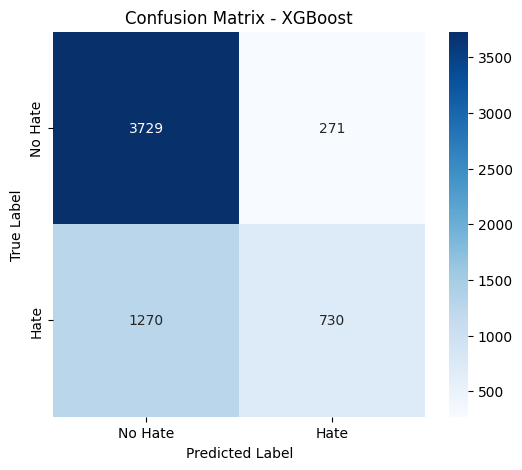

Confusion Matrix for SVM:


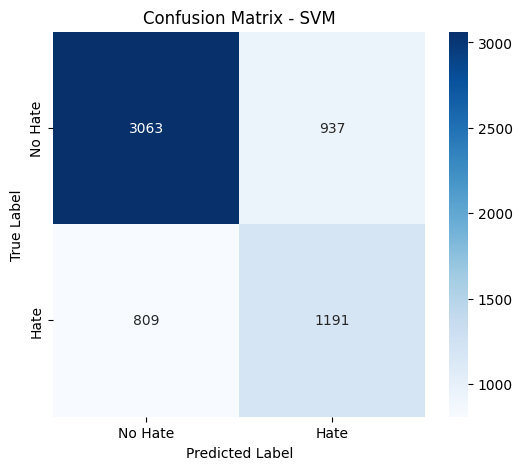

Confusion Matrix for Gradient Boosting:


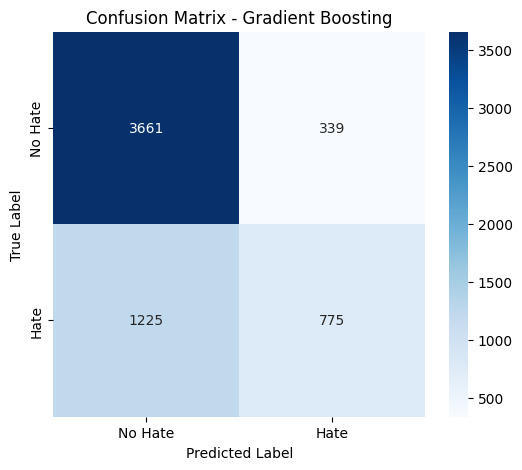

Confusion Matrix for Naïve Bayes:


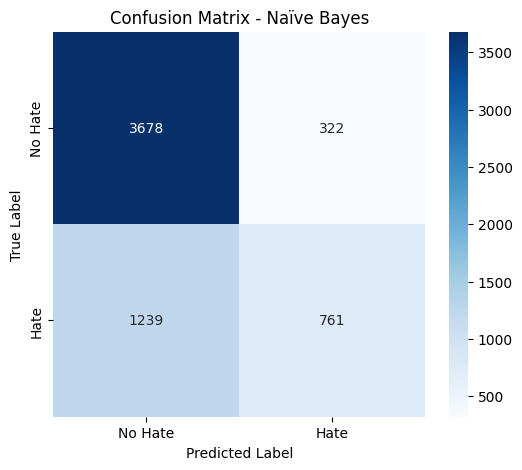

Confusion Matrix for KNN:


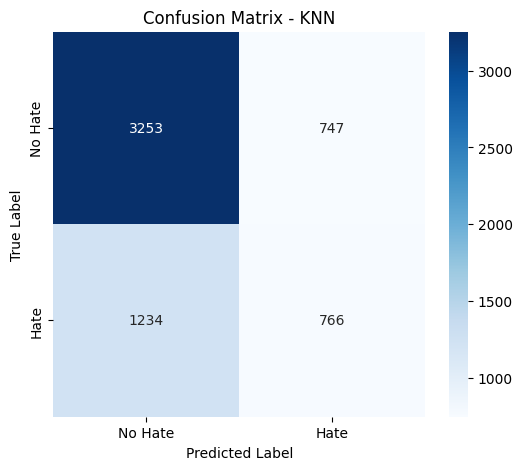

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score

# List of models and their predictions
model_predictions = {
    "XGBoost": (xgb_model, xgb_preds),
    "SVM": (svm_model, svm_preds),
    "Gradient Boosting": (gbt_model, gbt_preds),
    "Naïve Bayes": (nb_model, nb_preds),
    "KNN": (knn_model, knn_preds)
}

# ===============================
#  Confusion Matrices
# ===============================
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Hate", "Hate"], yticklabels=["No Hate", "Hate"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Generate confusion matrices for each model
for model_name, (_, preds) in model_predictions.items():
    print(f"Confusion Matrix for {model_name}:")
    plot_confusion_matrix(y_test, preds, model_name)


<ipython-input-17-56b5613faa01>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette="viridis")


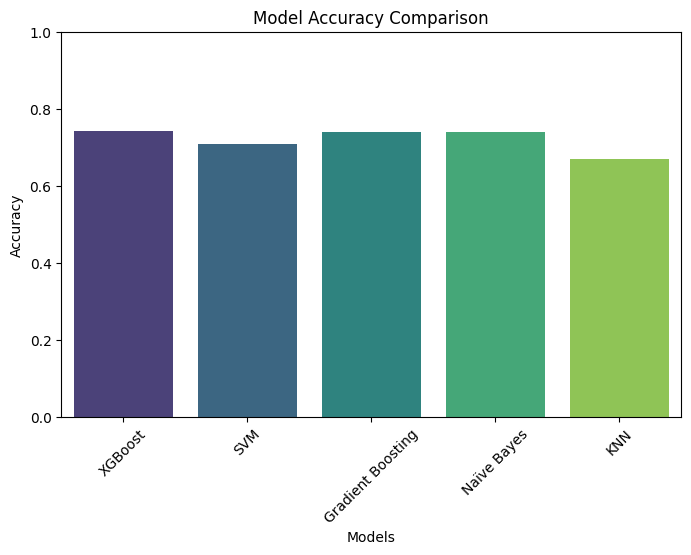

In [ ]:
# ===============================
#  Accuracy Comparison Bar Chart
# ===============================
model_accuracies = {name: accuracy_score(y_test, preds) for name, (_, preds) in model_predictions.items()}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette="viridis")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()